! pip install -U --user hmmlearn

# Example

In [6]:
from __future__ import print_function

import datetime

import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
try:
    from matplotlib.finance import quotes_historical_yahoo_ochl
except ImportError:
    # For Matplotlib prior to 1.5.
    from matplotlib.finance import (
        quotes_historical_yahoo as quotes_historical_yahoo_ochl
    )

from hmmlearn.hmm import GaussianHMM


print(__doc__)

Automatically created module for IPython interactive environment


In [281]:
quotes = quotes_historical_yahoo_ochl( 
    "AAPL", datetime.date(2014, 9, 6), datetime.date(2016, 3, 31))

# Unpack quotes
dates = np.array([q[0] for q in quotes], dtype=int)
close_v = np.array([q[2] for q in quotes])
volume = np.array([q[5] for q in quotes])[1:]
open_v = np.array([q[1] for q in quotes])
high_v = np.array([q[3] for q in quotes])
low_v = np.array([q[4] for q in quotes])

# Take diff of close value. Note that this makes
# ``len(diff) = len(close_t) - 1``, therefore, other quantities also
# need to be shifted by 1.

diff = np.diff(close_v)
dates = dates[1:]
gap = close_v[1:] - open_v[0:(len(open_v)-1)]
# close_v = close_v[1:]
# open_v =open_v[1:]
# diff_op = np.diff(open_v)
# high_v = high_v[1:]
# low_v = low_v[1:]


# Pack diff and volume for training.
# X = np.column_stack([diff, diff_op])
# X = diff
# quotes
X = np.column_stack([diff, gap, volume])

In [279]:
len(open_v)

393

In [282]:
# Make an HMM instance and execute fit
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

Transition matrix
[[  5.20500416e-01   7.90387109e-02   3.30968340e-01   6.94925331e-02]
 [  1.47429258e-01   6.80357336e-01   1.72213406e-01   3.69758126e-30]
 [  1.25920657e-01   3.14023477e-01   4.99808471e-01   6.02473946e-02]
 [  1.42216108e-03   1.34442637e-21   4.63461809e-01   5.35116030e-01]]

Means and vars of each hidden state
0th hidden state
mean =  [ -1.54458546e+00  -2.46087350e+00   6.20253720e+07]
var =  [  1.81669900e+00   1.62468543e+00   1.65507496e+14]

1th hidden state
mean =  [ -1.33290190e-01  -2.21884417e-02   3.56836804e+07]
var =  [  7.58591562e-01   1.22616636e+00   5.50986572e+13]

2th hidden state
mean =  [  1.30647705e+00   1.75774882e+00   5.17077687e+07]
var =  [  1.66465791e+00   2.03757260e+00   9.18690504e+13]

3th hidden state
mean =  [ -5.30651553e-01  -1.34648159e+00   1.00131367e+08]
var =  [  1.29849467e+01   1.78364610e+01   8.21613508e+14]



/Users/sheliaxin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 394 but corresponding boolean dimension is 393


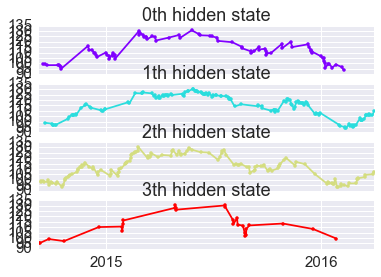

In [283]:
print("Transition matrix")
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
colours = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

plt.show()

$P(Z_n | x_1 \dots, x_n) $

In [284]:
Zn_post = model.predict_proba(X)[-1]

$P(Z_{n+1}, Z_{n} | X_1, \dots, X_n) = P(Z_{n+1} | Z_n) * P(Z_n | x_1 \dots, x_n)$

In [285]:
Zn1Zn = (model.transmat_.T * Zn_post).T

$P(Z_{n+1} | X_1, \dots, X_n) = \sum_{i=1}^{4} P(Z_{n+1}, Z_{n} =i | X_1, \dots, X_n) $

In [286]:
Zn1_post = np.sum(Zn1Zn, axis = 0)

In [287]:
Zn1_post 

array([ 0.14734989,  0.67616891,  0.17568058,  0.00080062])

In [288]:
import scipy.stats as sp
def mix_normal(x):
    r = 0
    for i in range(4):
        r += sp.norm.pdf(x,model.means_[i][0],model.covars_[i][0,0])*Zn1_post[i]
    return r

-0.13000130001299226

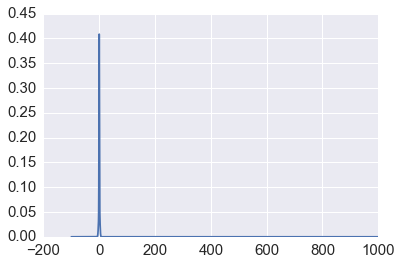

In [289]:
import matplotlib.pyplot as plt
x = np.linspace(-100,1000,100000)
plt.plot(x,mix_normal(x))
x[np.argmax(mix_normal(x))]

In [290]:
test = quotes_historical_yahoo_ochl(
    "AAPL", datetime.date(2016, 3, 1), datetime.date(2016, 3, 2))

In [291]:
test

[(736024.0,
  97.650002000000001,
  100.529999,
  100.769997,
  97.419998000000007,
  50153900.0),
 (736025.0, 100.510002, 100.75, 100.889999, 99.639999000000003, 33084900.0)]